In [301]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
from pandas import Series, DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Reading CSV file into training set
defined = pd.read_csv('TSE(original).csv',usecols=[4])
inputs = pd.read_csv('TSE(original).csv',usecols=[1,4,13])
defined.head()

,Close
0,7468.22
1,7361.94
2,7391.15
3,7371.44
4,7397.06


In [302]:
defined=defined.values
inputs=inputs.values
inputs=np.array(inputs)
print(inputs.shape, inputs)
print(defined.shape)

(1341, 3) [[  7504.45   7468.22     72.38]
 [  7440.56   7361.94     70.99]
 [  7379.48   7391.15     68.12]
 ..., 
 [ 11189.57  11076.78    131.78]
 [ 11054.36  11103.79    130.53]
 [ 11139.4   11160.25    128.85]]
(1341, 1)


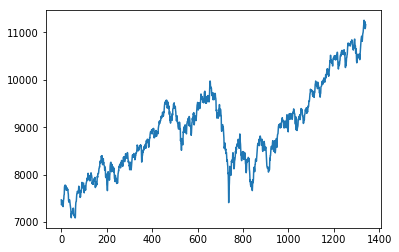

In [303]:
%matplotlib inline
plt.plot(defined)
plt.show()

In [304]:
def create_dataset(dataset, look_back=1,col=1):

    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back+1):
            dataX.append(dataset[i:(i+look_back),:])
            dataY.append(dataset[i+look_back-1,:])

    return np.array(dataX), np.array(dataY)

In [305]:
#data normalization
scaler = MinMaxScaler(feature_range=(0,1))
defined= scaler.fit_transform(defined)
inputs= scaler.fit_transform(inputs)
look_back=5
col=3

train_size= int(len(defined)*0.8)
test_size= len(defined)-train_size

data, o= create_dataset(inputs,look_back,3)
x_train,x_test= data[0:train_size,:],data[train_size:len(data),:]
print(x_train.shape,x_test[0:5])

(1072, 5, 3) [[[ 0.51754796  0.52451124  0.64477167]
  [ 0.52408104  0.5278921   0.64526803]
  [ 0.52481771  0.5449837   0.65008982]
  [ 0.54634828  0.54836456  0.65848067]
  [ 0.54757687  0.54120904  0.66807696]]

 [[ 0.52408104  0.5278921   0.64526803]
  [ 0.52481771  0.5449837   0.65008982]
  [ 0.54634828  0.54836456  0.65848067]
  [ 0.54757687  0.54120904  0.66807696]
  [ 0.5397522   0.54294269  0.67741326]]

 [[ 0.52481771  0.5449837   0.65008982]
  [ 0.54634828  0.54836456  0.65848067]
  [ 0.54757687  0.54120904  0.66807696]
  [ 0.5397522   0.54294269  0.67741326]
  [ 0.5460478   0.54200623  0.68639501]]

 [[ 0.54634828  0.54836456  0.65848067]
  [ 0.54757687  0.54120904  0.66807696]
  [ 0.5397522   0.54294269  0.67741326]
  [ 0.5460478   0.54200623  0.68639501]
  [ 0.54264314  0.55747943  0.69644039]]

 [[ 0.54757687  0.54120904  0.66807696]
  [ 0.5397522   0.54294269  0.67741326]
  [ 0.5460478   0.54200623  0.68639501]
  [ 0.54264314  0.55747943  0.69644039]
  [ 0.54690321  0.5

In [306]:
## define [0,1][1,0]
def create_updown(dataset):
    dataY=[]
    for i in range (len(dataset)):
        if(i+1)<len(dataset):
            a= dataset[i+1]-dataset[i]
            if np.any(a>0):
                dataY.append([0,1])
            else:
                dataY.append([1,0])
    dataY.append([1,0])
    return np.array(dataY,dtype='float32')

In [307]:
y_data=create_updown(defined)
y_train, y_test= y_data[look_back-1:train_size+4,:],y_data[train_size+4:len(defined),:]

print(defined.shape, y_data[0:5],y_train.shape, y_test.shape)


(1341, 1) [[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]] (1072, 2) (265, 2)


In [308]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1072, 5, 3) (1072, 2) (265, 5, 3) (265, 2)


In [309]:
tf.reset_default_graph()
training_rate=0.001
batchsize=10
displaystep=200

n_input=3 
n_steps=5
n_hidden=100
n_classes=2   

x=tf.placeholder("float",[None,n_steps,n_input])
y=tf.placeholder("float",[None,n_classes])

weights ={
    #'hidden':tf.Variable(tf.random_normal([n_input,n_hidden])),
    'out':tf.Variable(tf.random_normal([n_hidden,n_classes]))
}
biaes={
    #'hidden':tf.Variable(tf.random_normal([n_hidden])),
     'out':tf.Variable(tf.random_normal([n_classes]))
}
print(x.shape)


(?, 5, 3)


In [310]:
def RNN (x,weights,biaes):
    #x=tf.unstack(x,n_steps,1)
    print(x)
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    #outputs, states=rnn.static_rnn(lstm_cell,x,dtype=tf.float32)
    outputs, states=tf.nn.dynamic_rnn(lstm_cell,x,dtype=tf.float32)
    outputs=tf.transpose(outputs, [1, 0, 2])[-1]
    out= tf.matmul(outputs,weights['out'])+biaes['out']
    print("rnn out",out.shape)
    return out

In [311]:
logits= RNN(x,weights,biaes)
prediction=tf.nn.softmax(logits)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))

optimizer= tf.train.AdamOptimizer(learning_rate=training_rate).minimize(loss_op)

init=tf.global_variables_initializer()

Tensor("Placeholder:0", shape=(?, 5, 3), dtype=float32)
rnn out (?, 2)


In [312]:
correct_predict=tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))
accuracy= tf.reduce_mean(tf.cast(correct_predict,"float"))

In [313]:
trainEpochs=100
batchsize=100
loss_train=[];epoch_list=[];accuracy_train=[]
loss_test=[]; accuracy_test=[]
totalbatchs= int(len(data)//batchsize)
from time import time
startTime=time()

sess=tf.Session()
sess.run(tf.global_variables_initializer())


In [314]:
x_train.shape

(1072, 5, 3)

In [315]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(trainEpochs):
        shuffle = np.random.permutation(len(y_train)-1)
        x_train = x_train[shuffle]
        y_train = y_train[shuffle]
        for i in range(totalbatchs):
            sess.run(optimizer,feed_dict={x:x_train,y:y_train}) 
    
        #loss,acc= sess.run([loss_op, accuracy],feed_dict={x:x_train,y:y_train})
        loss_tra,acc_tra= sess.run([loss_op, accuracy],feed_dict={x:x_train,y:y_train})
        loss_t,acc_t= sess.run([loss_op, accuracy],feed_dict={x:x_test,y:y_test})

        epoch_list.append(epoch);
        loss_test.append(loss_t)
        loss_train.append(loss_tra)
        accuracy_test.append(acc_t)
        accuracy_train.append(acc_tra)

duration= time()-startTime
print("Loss_train= ",loss_tra)
print ("Loss_test= ",loss_t)

print("Accuracy_train= ", acc_tra)
print("Accuracy_test= ", acc_t)

print ("Trained Finished takes:" , duration)

Loss_train=  0.670107
Loss_test=  0.735616
Accuracy_train=  0.566872
Accuracy_test=  0.426415
Trained Finished takes: 61.144400119781494


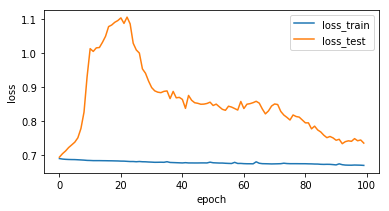

In [316]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.plot(epoch_list,loss_train, label='loss_train')
plt.plot(epoch_list,loss_test, label='loss_test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

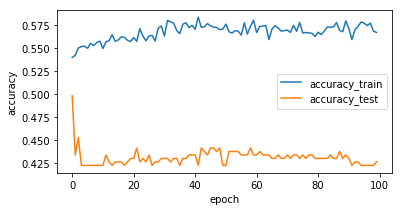

In [317]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.plot(epoch_list,accuracy_train, label='accuracy_train')
plt.plot(epoch_list,accuracy_test, label='accuracy_test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [318]:
# Visualizing the results
#plt.plot(real_stock_price, color = 'red', label = 'Real Tesla Stock Price')
#plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Tesla Stock Price')
#plt.title('Tesla Stock Price Prediction')
#plt.xlabel('Days')
#plt.ylabel('Tesla Stock Price')
#plt.legend()
#plt.show()

In [319]:
# Getting the real stock price of 2012 - 2016
#real_stock_price_train = pd.read_csv('TSE(original).csv')
#real_stock_price_train = real_stock_price_train.iloc[:,1:2].values

# Getting the predicted stock price of 2012 - 2016
#predicted_stock_price_train = regressor.predict(X_train)
#predicted_stock_price_train = sc.inverse_transform(predicted_stock_price_train)

# Visualising the results
#plt.plot(real_stock_price_train, color = 'red', label = 'Real Tesla Stock Price')
#plt.plot(predicted_stock_price_train, color = 'blue', label = 'Predicted Tesla Stock Price')
#plt.title('5-year Tesla Stock Price Prediction')
#plt.xlabel('Days')
#plt.ylabel('Tesla Stock Price')
#plt.legend()
#plt.show()

In [320]:
#plt.plot(real_stock_price_train, color = 'red', label = 'Real Tesla Stock Price')
#plt.title('5-year Tesla Stock Prices')
#plt.xlabel('Days')
#plt.ylabel('Tesla Stock Price')
#plt.legend()
#plt.show()

In [321]:
#plt.plot(predicted_stock_price_train, color = 'blue', label = 'Predicted Tesla Stock Price')
#plt.title('5-year Tesla Stock Price Prediction')
#plt.xlabel('Days')
#plt.ylabel('Tesla Stock Price')
#plt.legend()
#plt.show()